<a href="https://colab.research.google.com/github/Suyeon-j/study_oml/blob/main/240312/w_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!! pip install -U open-metric-learning

['Requirement already satisfied: open-metric-learning in /usr/local/lib/python3.10/dist-packages (2.1.6)',
 'Requirement already satisfied: torch<=2.1.1,>=2.0 in /usr/local/lib/python3.10/dist-packages (from open-metric-learning) (2.1.1)',
 'Requirement already satisfied: pytorch-lightning<=2.1.2,>=2.0 in /usr/local/lib/python3.10/dist-packages (from open-metric-learning) (2.1.2)',
 'Requirement already satisfied: torchvision<=0.16.1 in /usr/local/lib/python3.10/dist-packages (from open-metric-learning) (0.16.1)',
 'Requirement already satisfied: albumentations<=1.3.1,>=1.0 in /usr/local/lib/python3.10/dist-packages (from open-metric-learning) (1.3.1)',
 'Requirement already satisfied: opencv-python>=4.1.1 in /usr/local/lib/python3.10/dist-packages (from open-metric-learning) (4.8.0.76)',
 'Requirement already satisfied: pillow>=8.2 in /usr/local/lib/python3.10/dist-packages (from open-metric-learning) (9.4.0)',
 'Requirement already satisfied: pandas>=1.0 in /usr/local/lib/python3.10/

In [ ]:
# !pip install facenet-pytorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import os
# from PIL import Image
# from facenet_pytorch import MTCNN

# # MTCNN 초기화
# mtcnn = MTCNN(image_size=224, margin=20, min_face_size=20)

# # 파일 경로 지정
# dataset_root = "/content/drive/MyDrive/2024_공부/OML/img/pre_WOMAN"
# cropped_images_dir = "/content/drive/MyDrive/2024_공부/OML/img/WOMAN"

# # 이미지를 동일한 크기로 조정하고 얼굴을 자르는 변환 정의
# def transform_image_with_crop(image_path):
#     image = Image.open(image_path).convert('RGB')
#     boxes, _ = mtcnn.detect(image)
#     if boxes is not None:
#         # 얼굴이 감지된 경우
#         for i, box in enumerate(boxes):
#             x_min, y_min, x_max, y_max = box
#             cropped_face = image.crop((x_min, y_min, x_max, y_max))
#             cropped_face.save(os.path.join(cropped_images_dir, os.path.basename(image_path)))

# # 모든 이미지 파일에 대해 얼굴을 자르고 저장
# for filename in os.listdir(dataset_root):
#     if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
#         transform_image_with_crop(os.path.join(dataset_root, filename))

In [ ]:
import torch
from tqdm import tqdm

from oml.datasets.base import DatasetWithLabels
from oml.losses.triplet import TripletLossWithMiner
from oml.miners.inbatch_all_tri import AllTripletsMiner
from oml.models import ViTExtractor
from oml.samplers.balance import BalanceSampler
from oml.utils.download_mock_dataset import download_mock_dataset

In [ ]:
import os
os.chdir("/content/drive/MyDrive/2024_공부/OML/img/WOMAN")

# path
fpath = os.listdir()
path = sorted(fpath)

# label
n = 0
label = []
for i in path:
  fst = [word[0] for word in path]
  for letter in fst:
    if letter == fst[0]:
      label.append(n)
    else:
      break
  n += 1

  if len(label) >= len(path):
    break

In [ ]:
# split
split = ["train" for _ in label]
idx = int(len(label) * 0.7)

if label[idx] == label[idx - 1] and label[idx] == label[idx + 1]:
  idx -= 1

elif label[idx] == label[idx + 1]:
  idx += 1

for i in range(idx,len(split)):
  split[i] = "validation"

In [ ]:
# is_query, is_gallery
import numpy as np
is_query = ['NaN' for _ in label]
is_gallery = ['NaN' for _ in label]

for i in range(idx,len(label)):
  if label[i] != label[i - 1] and label[i] == label[i + 1]:
    is_query[i] = True
    is_gallery[i] = False
  else:
    is_query[i] = False
    is_gallery[i] = True

In [ ]:
# 테이블 생성
import os
os.chdir("/content/drive/MyDrive/2024_공부/OML/")
import sqlite3

conn = sqlite3.connect('img/w_img.db')
cursor = conn.cursor()

cursor.execute('''CREATE TABLE w_img
                  (label, path, split, is_query, is_gallery)''')

In [ ]:
# db에 데이터 삽입
for i in range(len(label)):
    cursor.execute("insert into w_img values (?, ?, ?, ?, ?)", (label[i], path[i], split[i], is_query[i], is_gallery[i]))

conn.commit()

In [ ]:
# DF 타입 출력
import pandas as pd

cursor.execute("SELECT * FROM w_img;")
rows = cursor.fetchall()

cols = [column[0] for column in cursor.description]

df = pd.DataFrame.from_records(data=rows, columns=cols)
conn.close()
df

,label,path,split,is_query,is_gallery
0,0,Anyujin01.jpeg,train,NaN,NaN
1,0,Anyujin02.jpeg,train,NaN,NaN
2,0,Anyujin03.jpeg,train,NaN,NaN
3,1,Goyunjeong01.jpeg,train,NaN,NaN
4,1,Goyunjeong02.jpeg,train,NaN,NaN
5,1,Goyunjeong03.jpeg,train,NaN,NaN
6,2,Hansohui01.jpg,train,NaN,NaN
7,2,Hansohui02.jpg,train,NaN,NaN
8,2,Hansohui03.jpg,train,NaN,NaN
9,3,Heoyunjin01.jpg,train,NaN,NaN


In [ ]:
import pandas as pd

df_train = df[df['split'] == "train"]
dataset_root = "img/WOMAN/"

In [ ]:
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 원하는 크기로 조정
    transforms.ToTensor(),  # 텐서로 변환
])

In [ ]:
image_paths = dataset_root + df["path"]

In [ ]:
# import cv2

# for img_path in image_paths:
#     image = cv2.imread(img_path)
#     print(f"이미지 경로: {img_path}, 이미지 크기: {image.shape}")

In [ ]:
model = ViTExtractor("vits16_dino", arch="vits16", normalise_features=False).train()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)
train_dataset = DatasetWithLabels(df_train, dataset_root=dataset_root, transform=image_transform)
criterion = TripletLossWithMiner(margin=0.1, miner=AllTripletsMiner(), need_logs=True)
sampler = BalanceSampler(train_dataset.get_labels(), n_labels=2, n_instances=2)

https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth


In [ ]:
# torch.utils.data.DataLoader(): 데이터를 미니배치 형태로 만듦
train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=sampler)

In [ ]:
for batch in tqdm(train_loader):
    embeddings = model(batch["input_tensors"])

    loss = criterion(embeddings, batch["labels"])
    print("\n",batch["input_tensors"], "\n", batch["labels"])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # info for logging: positive/negative distances, number of active triplets
    print(criterion.last_logs)

  0%|          | 0/2 [00:00<?, ?it/s]


 tensor([[[[0.0824, 0.0745, 0.0706,  ..., 0.1608, 0.1490, 0.1529],
          [0.0863, 0.0824, 0.0784,  ..., 0.1804, 0.1608, 0.1490],
          [0.0863, 0.0824, 0.0824,  ..., 0.2039, 0.1804, 0.1569],
          ...,
          [0.1294, 0.1412, 0.1255,  ..., 0.0902, 0.0902, 0.0824],
          [0.1490, 0.1333, 0.1176,  ..., 0.0902, 0.0902, 0.0824],
          [0.1490, 0.1255, 0.1176,  ..., 0.0902, 0.0941, 0.0902]],

         [[0.0902, 0.0824, 0.0784,  ..., 0.1529, 0.1412, 0.1451],
          [0.0863, 0.0784, 0.0784,  ..., 0.1725, 0.1529, 0.1412],
          [0.0824, 0.0784, 0.0784,  ..., 0.1961, 0.1725, 0.1490],
          ...,
          [0.1098, 0.1216, 0.1059,  ..., 0.0863, 0.0863, 0.0784],
          [0.1294, 0.1137, 0.0980,  ..., 0.0863, 0.0863, 0.0784],
          [0.1294, 0.1059, 0.0980,  ..., 0.0863, 0.0902, 0.0863]],

         [[0.1412, 0.1333, 0.1294,  ..., 0.2039, 0.1922, 0.1961],
          [0.1412, 0.1333, 0.1294,  ..., 0.2235, 0.2039, 0.1922],
          [0.1373, 0.1333, 0.1333,  ...,

 50%|█████     | 1/2 [00:03<00:03,  3.09s/it]

{'active_tri': 0.5, 'pos_dist': 56.29030990600586, 'neg_dist': 57.76230239868164}

 tensor([[[[0.3176, 0.2745, 0.2157,  ..., 0.2431, 0.2627, 0.2784],
          [0.2706, 0.2431, 0.2000,  ..., 0.2471, 0.2588, 0.2745],
          [0.2157, 0.2000, 0.1804,  ..., 0.2431, 0.2549, 0.2667],
          ...,
          [0.3373, 0.3373, 0.3294,  ..., 0.3922, 0.3961, 0.3961],
          [0.3333, 0.3333, 0.3294,  ..., 0.3961, 0.3922, 0.3804],
          [0.3294, 0.3294, 0.3294,  ..., 0.4039, 0.3882, 0.3686]],

         [[0.2745, 0.2314, 0.1725,  ..., 0.1608, 0.1804, 0.1961],
          [0.2275, 0.2000, 0.1569,  ..., 0.1647, 0.1765, 0.1922],
          [0.1725, 0.1569, 0.1373,  ..., 0.1608, 0.1725, 0.1843],
          ...,
          [0.1961, 0.1961, 0.1961,  ..., 0.2745, 0.2745, 0.2745],
          [0.1922, 0.1922, 0.1882,  ..., 0.2784, 0.2706, 0.2588],
          [0.1882, 0.1882, 0.1882,  ..., 0.2863, 0.2667, 0.2471]],

         [[0.3059, 0.2627, 0.2039,  ..., 0.2196, 0.2392, 0.2549],
          [0.2588, 0.231

100%|██████████| 2/2 [00:06<00:00,  3.39s/it]

{'active_tri': 0.5, 'pos_dist': 52.415931701660156, 'neg_dist': 56.255340576171875}


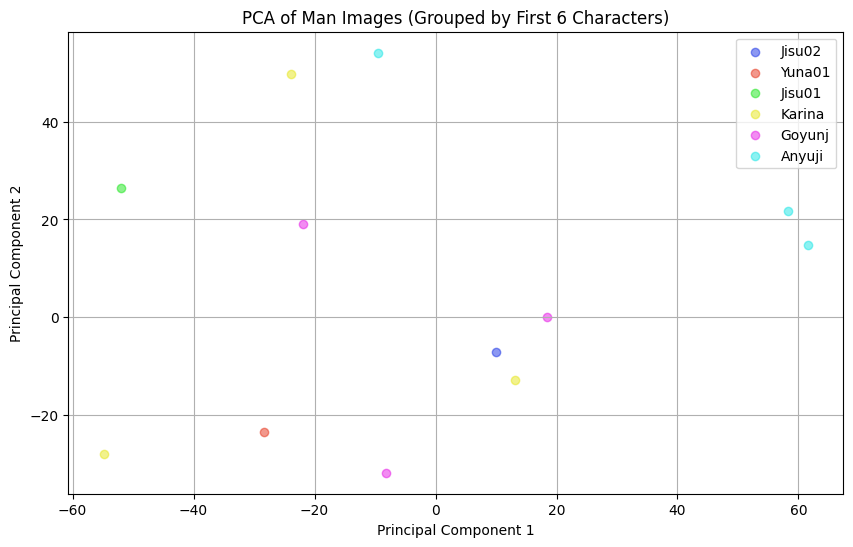

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torchvision import transforms

# 이미지 파일 폴더 경로
image_fpaths = '/content/drive/MyDrive/2024_공부/OML/img/WOMAN'

# 이미지 파일 목록 가져오기
image_files = os.listdir(image_fpaths)

# 이미지를 벡터로 변환하는 함수
def image_to_vector(image_path):
    image = Image.open(image_path).convert('RGB')

    image = image_transform(image)
    return image.flatten().numpy()  # 이미지를 1차원 벡터로 변환하여 반환

# 이미지를 벡터로 변환하고 이미지 이름을 그룹화한 후, 각 그룹의 색상을 결정
image_vectors = []
image_groups = []
for file_name in image_files:
    image_path = os.path.join(image_fpaths, file_name)
    image_vector = image_to_vector(image_path)
    image_vectors.append(image_vector)
    image_group = file_name[:6]  # 이미지 이름의 앞 6글자를 그룹화
    image_groups.append(image_group)

# 벡터 데이터를 numpy 배열로 변환
image_vectors = np.array(image_vectors)

# PCA 모델 초기화 및 학습
pca = PCA(n_components=2)  # 2차원으로 축소
pca.fit(image_vectors)

# PCA를 통해 데이터 변환
transformed_data = pca.transform(image_vectors)

# 각 그룹의 대표 색상 선택
unique_groups = list(set(image_groups))
colors = [
    (0.1, 0.2, 0.9),  # 첫 번째 그룹의 색상 (파란색)
    (0.9, 0.2, 0.1),  # 두 번째 그룹의 색상 (빨간색)
    (0.1, 0.9, 0.1),  # 세 번째 그룹의 색상 (초록색)
    (0.9, 0.9, 0.1),  # 네 번째 그룹의 색상 (노란색)
    (0.9, 0.1, 0.9),  # 다섯 번째 그룹의 색상 (자주색)
    (0.1, 0.9, 0.9),  # 여섯 번째 그룹의 색상 (하늘색)
]

# 시각화
plt.figure(figsize=(10, 6))
for group, color in zip(unique_groups, colors):
    group_indices = [i for i, g in enumerate(image_groups) if g == group]
    group_data = transformed_data[group_indices, :]
    plt.scatter(group_data[:, 0], group_data[:, 1], c=[color], label=group, alpha=0.5)
plt.title('PCA of Man Images (Grouped by First 6 Characters)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend()
plt.show()